# 03. Neural Network Classification with PyTorch

Classification is a problem of predicitng whether something is one thing or another (muliple things as options).



## 1. Make classification data and get it ready

In [299]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

print("Dataset created")

Dataset created


In [300]:
len(X), len(y)

(1000, 1000)

In [301]:
print(f"First 5 samples of X\n {X[:5]}")
print(f"First 5 samples of y\n {y[:5]}")


First 5 samples of X
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y
 [1 1 1 1 0]


In [302]:
# Make Dataframe of circles data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2":X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


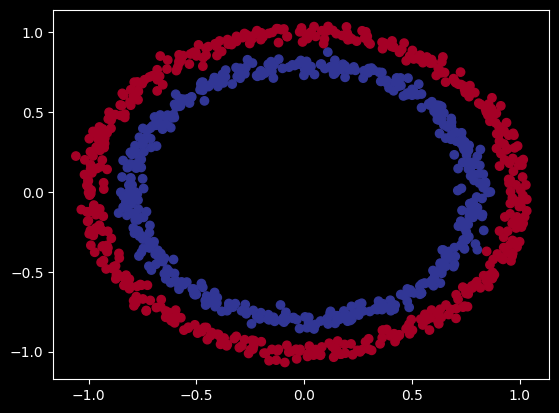

In [303]:
# Visuzalise, Visuzalise, Visuzalise
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

plt.show()

**Note**: The data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment and get the basics done.

### 1.1 Check input and output shapes

In [304]:
X.shape, y.shape

((1000, 2), (1000,))

In [305]:
print(type(X)) # NEED TO BE CONVERTED TO TORCH TENSORS

print(X.dtype) # float64 needs to be converted to float32 (torch prefernce)

<class 'numpy.ndarray'>
float64


In [306]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and same for y: 1
Shapes for one sample of X: (2,) and same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [307]:
# Turn data into tensors
import torch
torch.__version__

'2.3.1'

In [308]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [309]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [310]:
# Split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print("Splits created!")

Splits created!


In [311]:
len(X_train), len(X_test)

(800, 200)

In [312]:
len(y_train), len(y_test)

(800, 200)

## 2. Building a model

Let's build a model to classify our red and blue dots.

To do so, we want to:

1. Setup device agnostic code so our code will run on GPU if available

2. Construct a model (by subclassing `nn.Module`)

3. Define a loss function and optimizer

4. Building a train and test loop

In [313]:
# Import Pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device PyTorch is running on is '{device}'")

Device PyTorch is running on is 'cpu'


Now that we have setup device agnostic code, let's create a model that

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (forward propogation)
4. Instaniate an instance of our model class and send it to **target** device

In [314]:
# 1. Create an model that subclasses from nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear layers capable of handling our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from prev; layer and outputs a single feature and is same shape as y
    # 3. Forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> later_1 -> layer_2


# 4. Instaniate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [315]:
next(model_0.parameters()).device

device(type='cpu')

In [316]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [317]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [318]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")

print(f"\nFirst 10 predictions:\n {(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [319]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for a regression problem you might want to use MAE or MSE.

For classification you might binary cross entropy or categorical cross entropy (cross entropy).

In [320]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [321]:
# Calculate accuracy - out of a 100 examples what %age of our model gets right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to do the following:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Backpropogation
5. Gradient Descent

### 3.1 Going from raw logits -> prediction probabilites -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`.

In [322]:
# View the first outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [323]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilties
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For our prediction probabilitt values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [324]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimenstion once again
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [325]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set no. of Epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
  ### TRAINING
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze() # RAW LOGITS
  y_preds = torch.round(torch.sigmoid(y_logits)) # PREDICTION LABELS

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step (to reduce gradients)
  optimizer.step()

  ### TESTING
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # 3. Print out what's happenin'
    if (epoch % 10 == 0):
      print(f"Epcoh: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epcoh: 0 | Loss: 0.69796 | Acc: 51.88 | Test loss: 0.69440 | Test acc: 58.00
Epcoh: 10 | Loss: 0.69590 | Acc: 51.25 | Test loss: 0.69305 | Test acc: 53.00
Epcoh: 20 | Loss: 0.69490 | Acc: 51.62 | Test loss: 0.69254 | Test acc: 49.50
Epcoh: 30 | Loss: 0.69435 | Acc: 51.12 | Test loss: 0.69236 | Test acc: 49.50
Epcoh: 40 | Loss: 0.69401 | Acc: 50.88 | Test loss: 0.69232 | Test acc: 51.00
Epcoh: 50 | Loss: 0.69378 | Acc: 50.25 | Test loss: 0.69234 | Test acc: 50.00
Epcoh: 60 | Loss: 0.69362 | Acc: 50.00 | Test loss: 0.69239 | Test acc: 51.50
Epcoh: 70 | Loss: 0.69351 | Acc: 50.25 | Test loss: 0.69246 | Test acc: 51.00
Epcoh: 80 | Loss: 0.69342 | Acc: 49.88 | Test loss: 0.69254 | Test acc: 50.00
Epcoh: 90 | Loss: 0.69336 | Acc: 49.88 | Test loss: 0.69262 | Test acc: 53.00


## 4. Make predictions and eval. the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!


In other words, "Visualise, Visualise, Visualise"

In [326]:
import requests
from pathlib import Path

# Download helper functions from LearnPyTorch repo (if not already downlaoded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download.")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download.


In [327]:
from helper_functions import plot_predictions, plot_decision_boundary

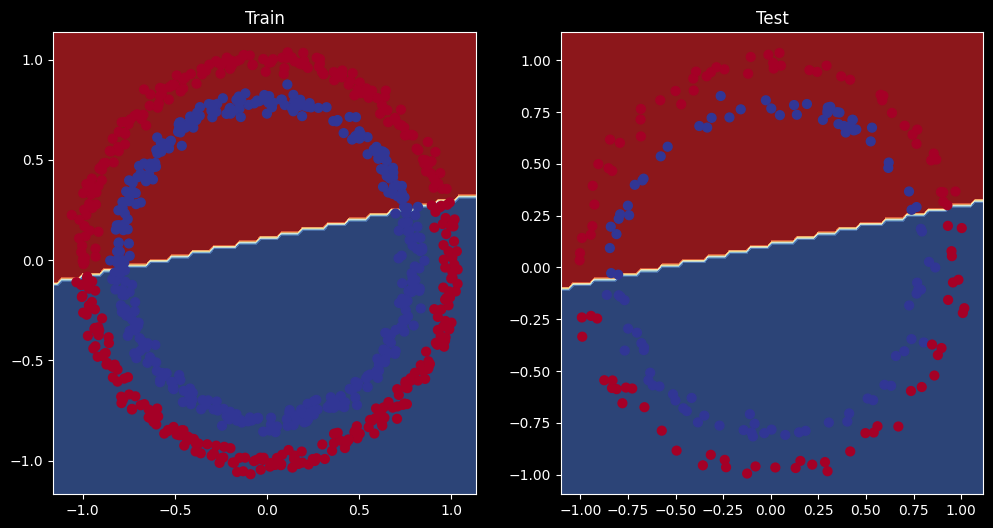

In [328]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

# TRAIN SUBPLOT
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

# TEST SUBPLOT
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model prespective)

* Add more layers - give the model more chances to learn about patterns in data

* Add more hidden units - go from 5 to 10 hidden units.

* Fit for longer (more epochs)

* Changing activations for functions

* Change the learnign rate (too small may not learn, or too large - never converges)

* Change the loss function

But the last 2 are pretty much fine and standard.



In [329]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)


  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [330]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [331]:
# Create a loss function
loss_dn = nn.BCEWithLogitsLoss()

# Create an optimzer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr=0.01)

In [332]:
# Train and test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

for epoch in range(epochs):
  ### TRAINING
  model_1.train()
  
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> prediction labels
  
  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  
  # 3. Optimize zero grad
  optimizer.zero_grad()
  
  # 4. Loss backward
  loss.backward()
  
  # 5. Optimizer step
  optimizer.step()
  
  ### TESTING
  model_1.eval()

  # Testing loop
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # 2. Calc. loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
    
  # Print out whats happenin'
  if (epoch % 100 == 0):
    print(f"Epcoh: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epcoh: 0 | Loss: 0.69396 | Acc: 50.88 | Test loss: 0.69261 | Test acc: 51.00
Epcoh: 100 | Loss: 0.69369 | Acc: 50.25 | Test loss: 0.69269 | Test acc: 50.00
Epcoh: 200 | Loss: 0.69351 | Acc: 50.12 | Test loss: 0.69282 | Test acc: 49.50
Epcoh: 300 | Loss: 0.69339 | Acc: 50.50 | Test loss: 0.69295 | Test acc: 49.00
Epcoh: 400 | Loss: 0.69329 | Acc: 50.38 | Test loss: 0.69309 | Test acc: 48.50
Epcoh: 500 | Loss: 0.69322 | Acc: 49.88 | Test loss: 0.69322 | Test acc: 49.50
Epcoh: 600 | Loss: 0.69317 | Acc: 49.50 | Test loss: 0.69335 | Test acc: 53.00
Epcoh: 700 | Loss: 0.69313 | Acc: 49.38 | Test loss: 0.69347 | Test acc: 50.50
Epcoh: 800 | Loss: 0.69309 | Acc: 50.00 | Test loss: 0.69358 | Test acc: 51.00
Epcoh: 900 | Loss: 0.69307 | Acc: 50.62 | Test loss: 0.69368 | Test acc: 47.50


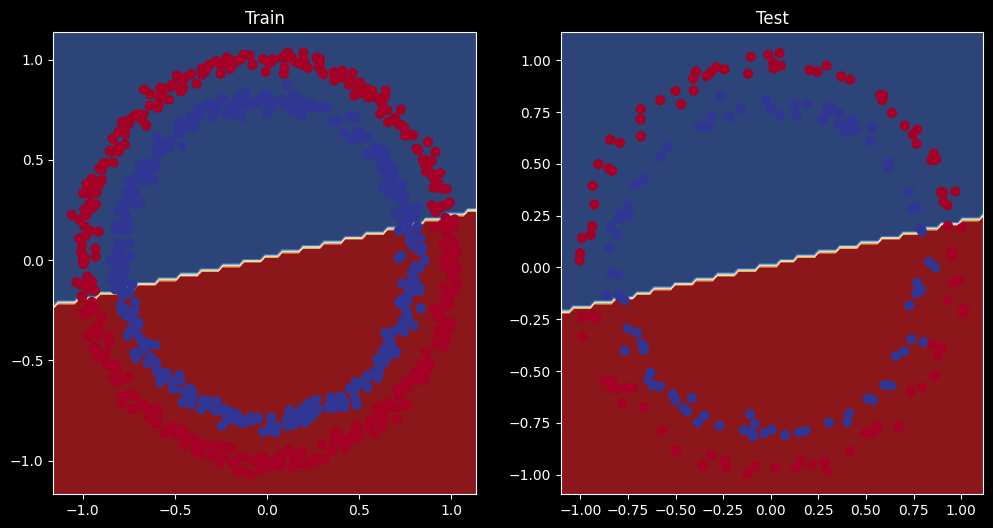

In [333]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))

# TRAIN SUBPLOT
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

# TEST SUBPLOT
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# 6. The missing piece: non-linearity

What patterns could you draw if you were given an infinite amount of a straight and non straight lines?

Or in ML terms, an infinite (but really is finite) of linear & non-linear functions.

### 6.1 Recreating non linear data (red & blue cirlces)

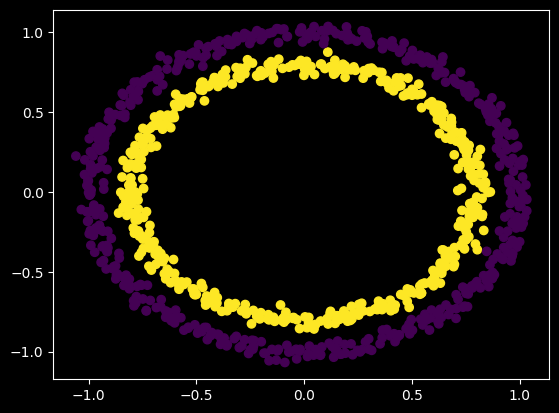

In [334]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [335]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train[:5], y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [336]:
# Build a model with non linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=128)
    self.layer_2 = nn.Linear(in_features=128, out_features=128)
    self.layer_3 = nn.Linear(in_features=128, out_features=128)
    self.layer_4 = nn.Linear(in_features=128, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))
    

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [337]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [338]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epochs
epochs = 1000

# Put data on target device
X_train, y_train, X_train.to(device), y_train.to(device)
X_test, y_test, X_test.to(device), y_test.to(device)


# Training loop
for epoch in range(epochs):
    ### Training
    model_3.train()
  
    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # Logits -> prediction probabilities -> prediction labels
    
    # Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  
    # Zero gradients
    optimizer.zero_grad()
  
    # Backpropagation
    loss.backward()
  
    # Step the optimizer
    optimizer.step()
  
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
      
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69496 | Acc: 50.00 | Test Loss: 0.69437 | Test Acc: 50.00
Epoch: 100 | Loss: 0.68784 | Acc: 63.25 | Test Loss: 0.68942 | Test Acc: 66.00
Epoch: 200 | Loss: 0.67751 | Acc: 75.38 | Test Loss: 0.68166 | Test Acc: 74.50
Epoch: 300 | Loss: 0.64105 | Acc: 91.62 | Test Loss: 0.65028 | Test Acc: 88.50
Epoch: 400 | Loss: 0.55024 | Acc: 55.50 | Test Loss: 0.67475 | Test Acc: 50.00
Epoch: 500 | Loss: 0.38025 | Acc: 77.88 | Test Loss: 0.44505 | Test Acc: 68.50
Epoch: 600 | Loss: 0.06584 | Acc: 100.00 | Test Loss: 0.09674 | Test Acc: 100.00
Epoch: 700 | Loss: 0.02394 | Acc: 100.00 | Test Loss: 0.04319 | Test Acc: 100.00
Epoch: 800 | Loss: 0.01355 | Acc: 100.00 | Test Loss: 0.02811 | Test Acc: 100.00
Epoch: 900 | Loss: 0.00920 | Acc: 100.00 | Test Loss: 0.02133 | Test Acc: 100.00


In [339]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6143,  0.6579],
                      [-0.2880,  0.8001],
                      [-0.1994,  0.1539],
                      [-0.4142,  0.4764],
                      [ 0.6395, -0.5032],
                      [ 0.7059,  0.1816],
                      [ 0.5641,  0.1025],
                      [ 0.4279, -0.1283],
                      [ 0.5564,  0.1034],
                      [-0.3365,  0.1882],
                      [-0.4154, -0.1206],
                      [-0.4313,  0.6036],
                      [-0.7892, -0.3836],
                      [-0.1997, -0.4252],
                      [ 0.0869, -0.7852],
                      [ 0.7565, -0.7520],
                      [ 0.5084,  0.1160],
                      [-0.2377,  0.4880],
                      [ 0.1027,  0.6886],
                      [ 0.0882, -0.3569],
                      [ 0.1900, -0.1918],
                      [ 0.3653,  0.7552],
                      [ 0.3941, -0.2522],
  

In [340]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

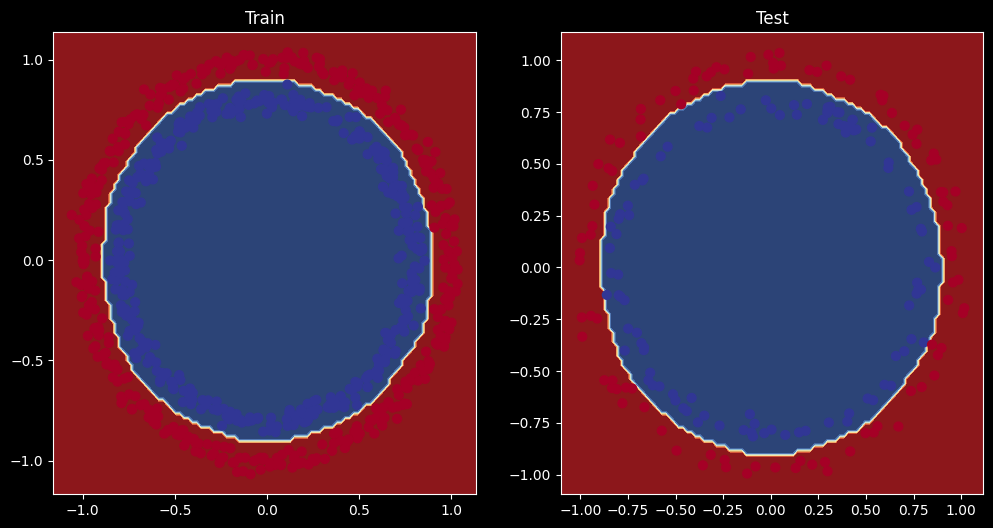

In [341]:
# Plot decision boundaries
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)



## 7. Putting it all together

Multi-class classification

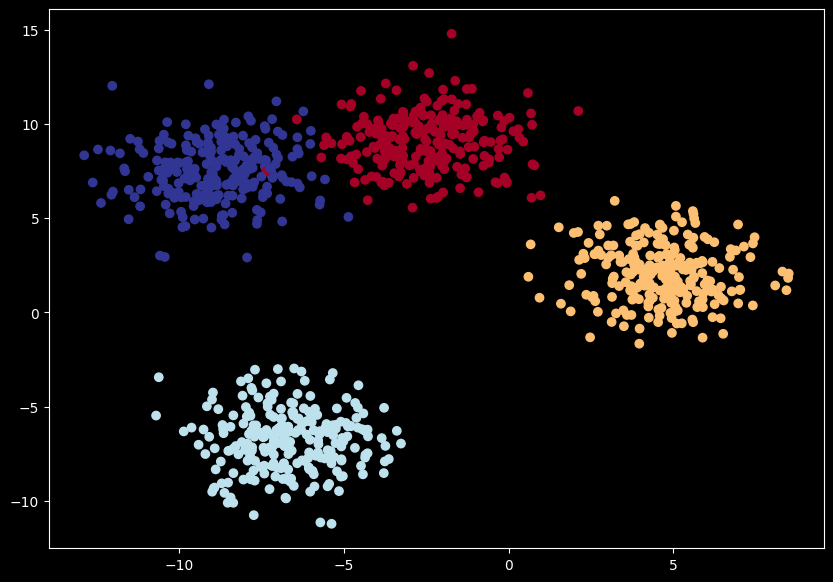

In [342]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES, 
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # to add some randomness
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [343]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [344]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi class classification model.
    
    Args: 
      input features (int): Number of input features to the model
      output features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_features),
      nn.ReLU()
    )
    
  def forward(self, x):
    return self.linear_layer_stack(x)
  

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
  )
)

In [345]:
# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [346]:
# Getting prediction probs for a multi-class PyTorch model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
  
print(y_blob_test[:5])
print(y_logits[:5])

# Convert our model's logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:5])

# Convert our model pred. probs to pred. labels
y_preds = torch.argmax(y_pred_probs, dim=1)
print(y_preds[:5])

tensor([1., 3., 2., 1., 0.])
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.8125, 0.0000, 0.7427, 1.9673],
        [0.2863, 0.0000, 0.2584, 0.0986],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0392]])
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.1802, 0.0800, 0.1680, 0.5718],
        [0.2815, 0.2114, 0.2738, 0.2333],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.1716, 0.1716, 0.1716, 0.4852]])
tensor([0, 3, 0, 0, 3])


In [353]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs 
epochs = 300

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training 
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train.type(torch.int64))
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
    test_loss = loss_fn(test_logits, y_blob_test.type(torch.int64))
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
    
  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.4042, Acc: 73.12% | Test loss: 0.3190, Test acc: 79.00%
Epoch: 10 | Loss: 0.4000, Acc: 73.12% | Test loss: 0.3146, Test acc: 79.00%
Epoch: 20 | Loss: 0.3973, Acc: 73.12% | Test loss: 0.3117, Test acc: 79.00%
Epoch: 30 | Loss: 0.3954, Acc: 73.12% | Test loss: 0.3097, Test acc: 79.00%
Epoch: 40 | Loss: 0.3940, Acc: 73.12% | Test loss: 0.3081, Test acc: 79.00%
Epoch: 50 | Loss: 0.3928, Acc: 73.12% | Test loss: 0.3068, Test acc: 79.00%
Epoch: 60 | Loss: 0.3919, Acc: 73.12% | Test loss: 0.3058, Test acc: 79.00%
Epoch: 70 | Loss: 0.3912, Acc: 73.12% | Test loss: 0.3049, Test acc: 79.00%
Epoch: 80 | Loss: 0.3906, Acc: 73.12% | Test loss: 0.3042, Test acc: 79.00%
Epoch: 90 | Loss: 0.3901, Acc: 73.12% | Test loss: 0.3036, Test acc: 79.00%
Epoch: 100 | Loss: 0.3896, Acc: 73.12% | Test loss: 0.3031, Test acc: 79.00%
Epoch: 110 | Loss: 0.3892, Acc: 73.12% | Test loss: 0.3026, Test acc: 79.00%
Epoch: 120 | Loss: 0.3889, Acc: 73.12% | Test loss: 0.3022, Test acc: 79.00%
Epoch: 130

In [354]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 9.9545,  0.0000,  6.2048, 17.2292],
        [ 0.0000,  0.0000,  9.0834,  0.9982],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 6.7566,  0.0000,  0.0000,  0.0000],
        [11.6724,  0.0000,  7.3179, 20.4170],
        [ 0.0000,  0.0000,  8.0356,  1.0547],
        [ 8.3635,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 11.2024,  1.4356],
        [ 7.6972,  0.0000,  0.0000,  0.0000]])

In [355]:

# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]
     

tensor([[2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01],
        [6.9234e-04, 3.2896e-08, 1.6287e-05, 9.9929e-01],
        [1.1347e-04, 1.1347e-04, 9.9947e-01, 3.0790e-04],
        [2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01],
        [9.9652e-01, 1.1591e-03, 1.1591e-03, 1.1591e-03],
        [1.5930e-04, 1.3582e-09, 2.0468e-06, 9.9984e-01],
        [3.2322e-04, 3.2322e-04, 9.9843e-01, 9.2797e-04],
        [9.9930e-01, 2.3307e-04, 2.3307e-04, 2.3307e-04],
        [1.3640e-05, 1.3640e-05, 9.9992e-01, 5.7317e-05],
        [9.9864e-01, 4.5347e-04, 4.5347e-04, 4.5347e-04]])

In [356]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([0, 3, 2, 0, 0, 3, 2, 0, 2, 0])

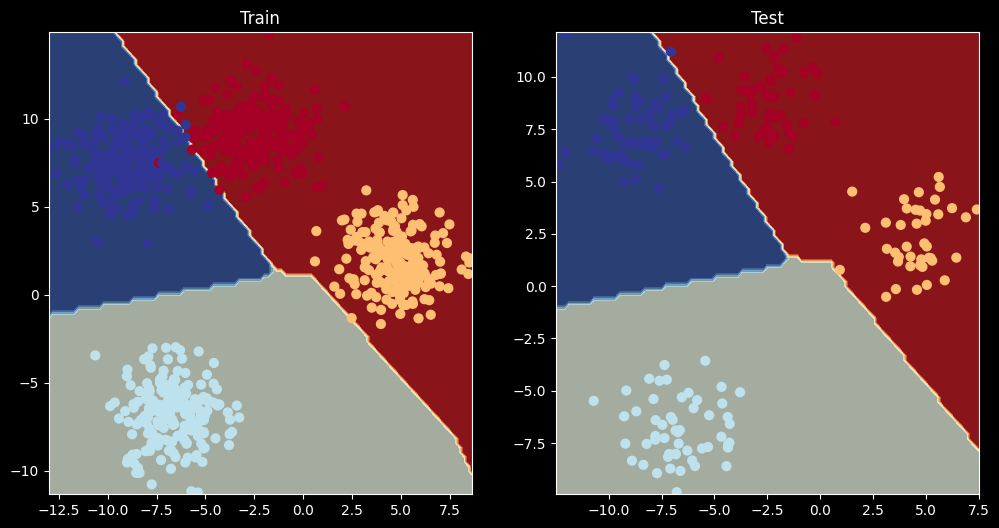

In [357]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [362]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)


tensor(0.7900)